## Putting it all together 

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
data = pd.read_csv("car-sales-extended-missing-data.csv")
data.dropna(subset = ["Price"], inplace= True)
data


categorical_features =["Make", "Colour"]

categorical_transformer = Pipeline (steps= [ # steps is a list containing tuples
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown= "ignore"))
    ## If set to "error" (default), it will crash when it encounters an unknown category.
    ## If set to "ignore", it will just skip it and output all zeros for that column.
])

door_features =["Doors"]

door_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value= round(np.mean(data["Doors"])))), # takes the mean and fills
    ##the door NAN coloumns with 4
])

numeric_features = ["Odometer (KM)"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

# set up preprocessing steps (fill missing values then convert coloumns to number)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("door", door_transformer, door_features ),
        ("num", numeric_transformer, numeric_features)
    ], 
    n_jobs=-1,
)

model = Pipeline(steps =[
    ("Preprocessor", preprocessor),
    ("model", RandomForestRegressor())
])

#split data
x = data.drop("Price", axis=1)
y = data["Price"]
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.2)
error_score="raise"


model.fit(x_train, y_train)
model.score(x_test, y_test)



 


0.22188417408787875

In [2]:
#use GrideSearchCV with our regression Pipeline
pipe_grid = {
    "Preprocessor__num__imputer__strategy" : ["mean", "median"],
    "model__n_estimators": [100, 500],
    "model__max_depth": [None, 5],
    "model__max_features": ["sqrt", "log2", None],
    "model__min_samples_split": [2, 4]
    
    
}


gs_model = GridSearchCV(model, pipe_grid, cv=5 , verbose =2)
gs_model.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100; total time=   2.0s
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100; total time=   0.5s
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100; total time=   0.5s
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100; total time=   0.6s
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100; total time=   0.5s
[CV] END Preprocessor__num__imputer__strategy=mean, model__max_depth=None

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Make',
                                                                          'Colour']),
                                                                        ('door',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=4,
                                                                                                        strategy='constant'))]),
                                                                         ['Doors']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['Odometer '
                                                                          '(KM)'])])),
                                       ('model', RandomForestRegressor())]),
             param_grid={'Preprocessor__num__imputer__strategy': ['mean',
                                                                  'median'],
                         'model__max_depth': [None, 5],
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__min_samples_split': [2, 4],
                         'model__n_estimators': [100, 500]},
             verbose=2)

In [3]:
gs_model.best_params_

{'Preprocessor__num__imputer__strategy': 'mean',
 'model__max_depth': 5,
 'model__max_features': 'log2',
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [4]:
y_preds= gs_model.predict(x_test)
y_preds[:10]

array([17967.70342939, 20142.69925218, 11870.47672515, 11090.3749137 ,
       11225.24780976, 13145.47249816, 15801.94468062, 12900.1025027 ,
       18169.76814522, 14287.23262483])

In [5]:
y_test[:10]

203    10547.0
979    17940.0
729    12950.0
838     5905.0
919     9826.0
601    11162.0
865    13650.0
974    14345.0
509    12024.0
178    10076.0
Name: Price, dtype: float64

In [6]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_preds)
print("R² Score:", r2)

gs_model.score(x_test, y_test)

R² Score: 0.296420611896301


0.296420611896301

In [8]:
round(np.mean(data["Doors"]))

4

In [9]:
clf = RandomForestRegressor()
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [19]:
data.dtypes


Make              object
Colour            object
Odometer (KM)    float64
Doors            float64
Price            float64
dtype: object

In [33]:
data.isna().sum()

Make             47
Colour           46
Odometer (KM)    48
Doors            47
Price             0
dtype: int64

ModuleNotFoundError: No module named 'kagglehub'

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [20]:
df = pd.read_csv("heart-disease.csv")
df


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Exploratory data analysis (EDA)
the goal here is to find our more abour the data and beome a subject matter expert 
1. where are the outliers and why we should care about them 
2. What questions are you trying to solve or raise
3. what's missing from the data and how do you deal with it
4. How can you add , change or removce feature to get more out of the data
5. what kind of data do we have and how do we treat different types ?

In [35]:
df["target"].value_counts()

target
1    165
0    138
Name: count, dtype: int64

<Axes: xlabel='target'>

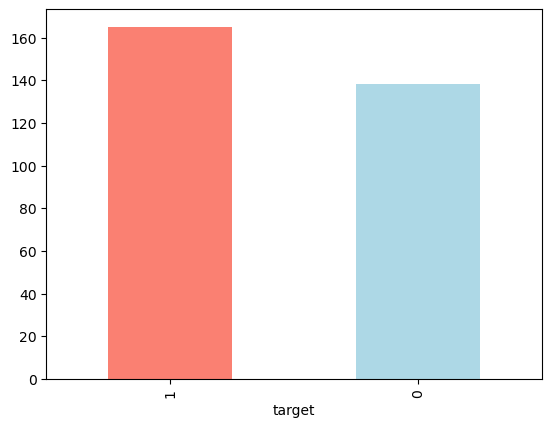

In [37]:
df["target"].value_counts().plot(kind= "bar", color =["salmon","lightblue"])

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [41]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [43]:
df.describe()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [53]:
# compare the coloumns to the target
df.sex.value_counts()

sex
1    207
0     96
Name: count, dtype: int64

In [51]:
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


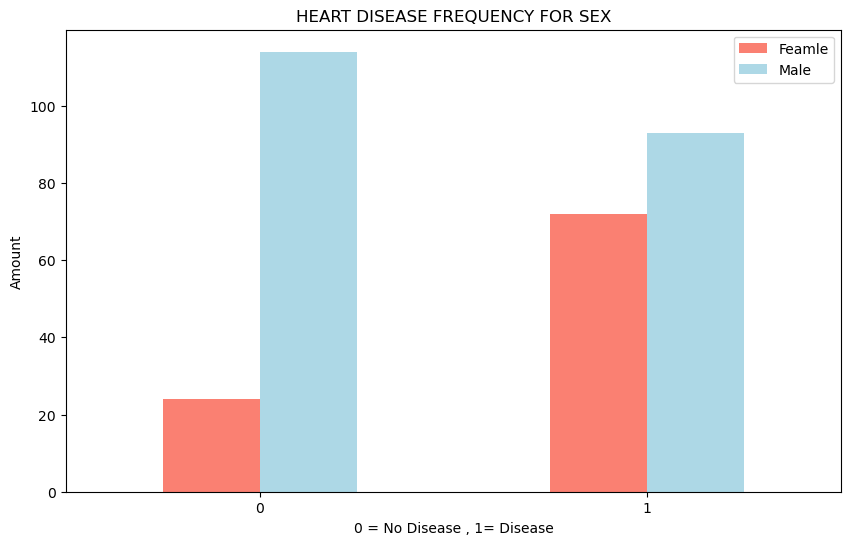

In [63]:
pd.crosstab(df.target, df.sex).plot(kind="bar", figsize=(10,6), color =["salmon","lightblue"])

plt.title("HEART DISEASE FREQUENCY FOR SEX")
plt.xlabel("0 = No Disease , 1= Disease")
plt.ylabel("Amount")
plt.legend(["Feamle", "Male"])
plt.xticks(rotation = 0);

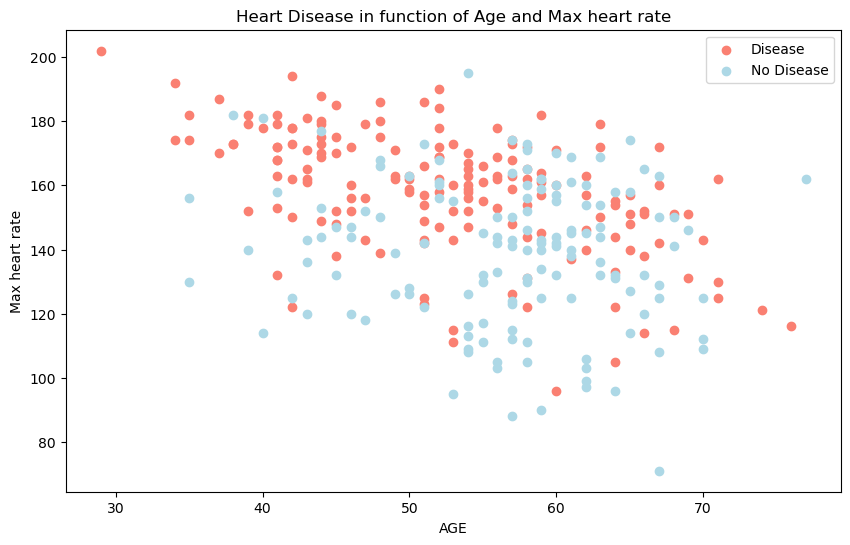

In [87]:
plt.figure(figsize=(10, 6))

plt.scatter(df.age[df.target ==1], 
           df.thalach[df.target ==1],
           c ="salmon")

plt.scatter(df.age[df.target ==0], 
           df.thalach[df.target ==0],
           c ="lightblue");

plt.xlabel("AGE")
plt.ylabel("Max heart rate")
plt.title("Heart Disease in function of Age and Max heart rate")
plt.legend(["Disease", "No Disease"]);


In [ ]:
## the younger someone is the higher their heart-rate

<Axes: ylabel='Frequency'>

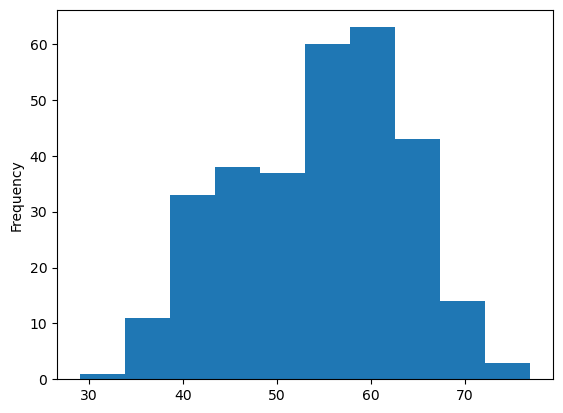

In [91]:
# check the distribution of the age coloumn with a histogram
df.age.plot.hist()

In [93]:
## heart disease frequency  per chest pain type 
pd.crosstab(df.cp,df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


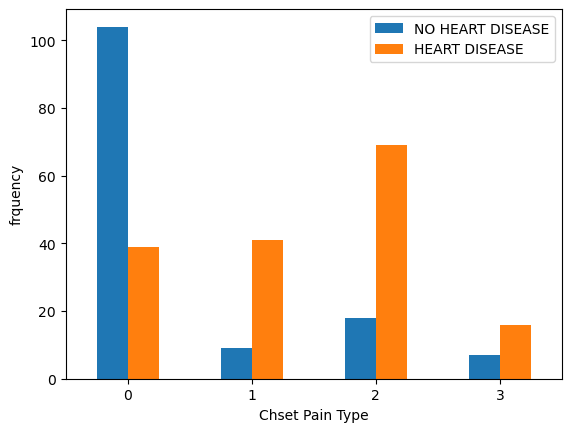

In [111]:
pd.crosstab(df.cp,df.target).plot(kind="bar", )
plt.legend(["NO HEART DISEASE","HEART DISEASE"])
plt.ylabel("frquency")
plt.xlabel("Chset Pain Type")
plt.xticks(rotation = 0);



In [101]:
## More heart disease noted in the nuber 2 when it statess it's non heart related spasm chest pain type

In [115]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


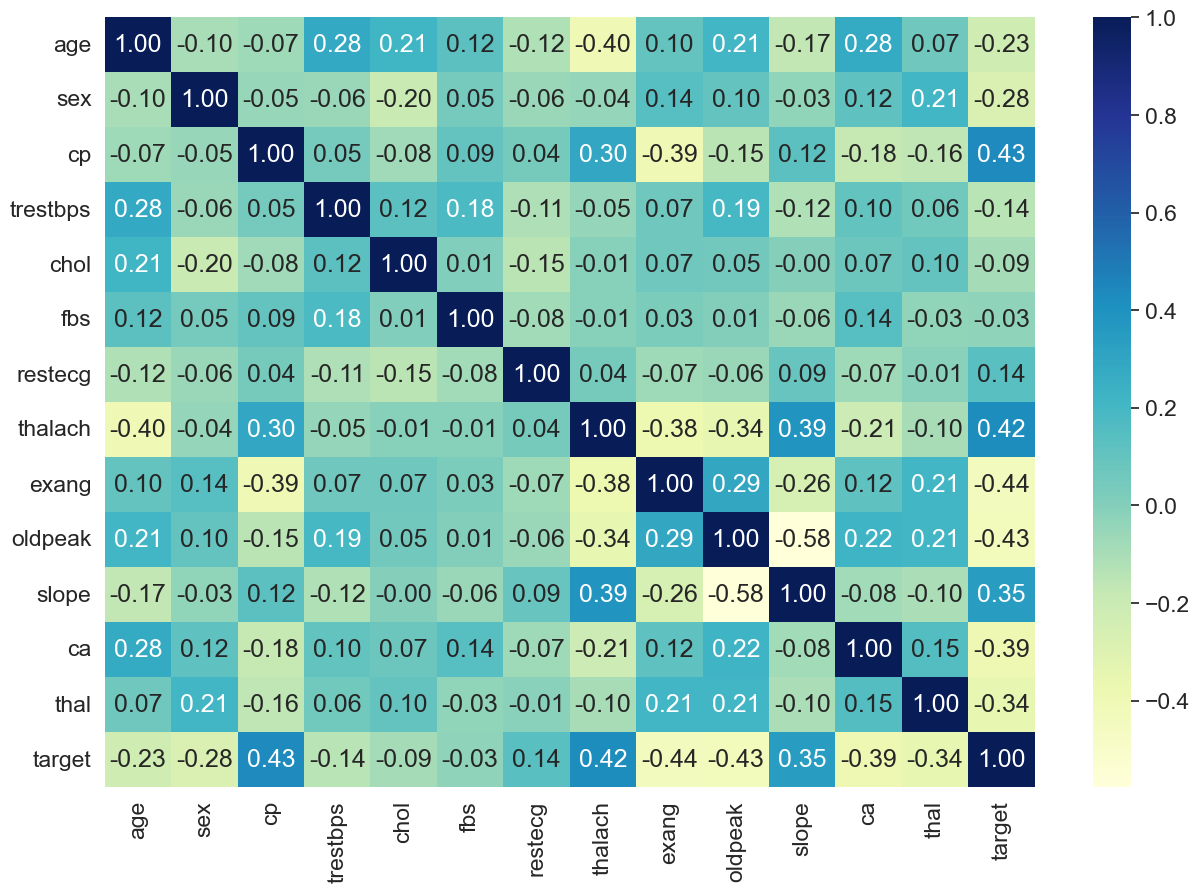

In [131]:
import seaborn as sns
sns.set(font_scale = 1.5)

corr_matrix = df.corr()

fig, ax = plt.subplots(figsize= (15, 10))

ax = sns.heatmap(corr_matrix, annot=True, fmt= ".2f", cmap ="YlGnBu" ); 

#a higher positive value has as  potentisal positive colleration (as cp goes up the target values also increases)
#Negative correlation ( a relationship between two variables inn which one variable increases a sthe other 
# decreases)